# Introduction. I want to classify any user image by training on availabe satellite image. The training and test data set DeepSat(SAT-4) Airborne Dataset is from https://www.kaggle.com/arpandhatt/satellite-image-classification.

SAT-4

SAT-4 consists of a total of 500,000 image patches covering four broad land cover classes. These include - barren land, trees, grassland and a class that consists of all land cover classes other than the above three. 400,000 patches (comprising of four-fifths of the total dataset) were chosen for training and the remaining 100,000 (one-fifths) were chosen as the testing dataset. We ensured that the training and test datasets belong to disjoint set of image tiles. Each image patch is size normalized to 28x28 pixels. Once generated, both the training and testing datasets were randomized using a pseudo-random number generator.

The MAT file for the SAT-4 dataset contains the following variables:

train_x	28x28x4x400000 uint8 (containing 400000 training samples of 28x28 images each with 4 channels)
train_y	400000x4 uint8 (containing 4x1 vectors having labels for the 400000 training samples)
test_x	28x28x4x100000 uint8 (containing 100000 test samples of 28x28 images each with 4 channels)
test_y	100000x4 uint8 (containing 4x1 vectors having labels for the 100000 test samples)

SAT-6

SAT-6 consists of a total of 405,000 image patches each of size 28x28 and covering 6 landcover classes - barren land, trees, grassland, roads, buildings and water bodies. 324,000 images (comprising of four-fifths of the total dataset) were chosen as the training dataset and 81,000 (one fifths) were chosen as the testing dataset. Similar to SAT-4, the training and test sets were selected from disjoint NAIP tiles. Once generated, the images in the dataset were randomized in the same way as that for SAT-4. The specifications for the various landcover classes of SAT-4 and SAT-6 were adopted from those used in the National Land Cover Data (NLCD) algorithm.

The MAT file for the SAT-6 dataset contains the following variables:

train_x	28x28x4x324000 uint8 (containing 324000 training samples of 28x28 images each with 4 channels)
train_y	324000x6 uint8 (containing 6x1 vectors having labels for the 324000 training samples)
test_x	28x28x4x81000 uint8 (containing 81000 test samples of 28x28 images each with 4 channels)
test_y	81000x6 uint8 (containing 6x1 vectors having labels for the 81000 test samples)



## Section 1 input data

In [1]:
#import modules
import os
import copy
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from math import ceil
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.io import imread, imshow, concatenate_images
from sklearn.neighbors import NearestNeighbors
from keras.applications.vgg19 import preprocess_input

# My add on
from PIL import Image
from sklearn import metrics

In [2]:
# read the satellite image csv file. The original file has 400,000 train samples and 100,000 test samples. 
x_train = pd.read_csv("X_train_sat4.csv", header=None)
x_test = pd.read_csv("X_test_sat4.csv", header=None)
y_train = pd.read_csv("y_train_sat4.csv", header=None)
y_test = pd.read_csv("y_test_sat4.csv", header=None)

In [3]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,104,103,94,133,114,115,106,145,104,110,...,95,141,101,103,92,138,103,110,99,148
1,175,149,130,146,169,148,130,141,166,139,...,119,132,137,133,121,134,134,128,119,132
2,113,114,105,163,126,131,125,176,119,125,...,129,177,122,126,113,172,130,136,131,181
3,107,104,100,124,108,105,102,126,105,104,...,74,85,74,70,63,78,83,79,73,92
4,105,100,95,132,77,72,62,114,76,77,...,86,129,106,100,85,128,118,109,99,130


In [4]:
x_train.shape

(400000, 3136)

In [5]:
y_train.shape

(400000, 4)

In [6]:
x_test.shape

(100000, 3136)

In [7]:
y_test.shape

(100000, 4)

## Section 2 EDA

In [8]:
#Convert the training and testing data into numpy array with shape of [image no, 28,28,4]
x_train_img = x_train.to_numpy().reshape([400000,28,28,4])
x_test_img = x_test.to_numpy().reshape([100000,28,28,4])

In [89]:
#convert x from pandas dataframe to numpy array
x_train_np = x_train.to_numpy()
x_test_np = x_test.to_numpy()

In [9]:
#convert label y from pandas dataframe to numpy array
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

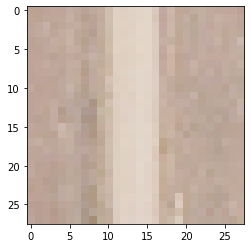

Barren Land


In [10]:
# Examine the image. The color channel are R,G,B, and I(Infrared)
# Type a image number between 0 and 400,000 to check the image.
ix = 10000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

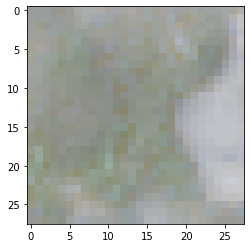

Trees


In [11]:
ix = 5000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

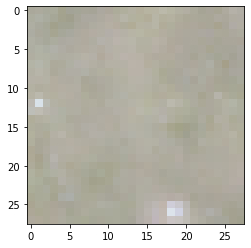

Grassland


In [12]:
ix = 39999
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

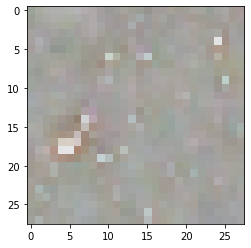

Other


In [13]:
ix = 20000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

In [14]:
# Check how many images in each class
sum = [0,0,0,0]
for i in range(len(y_train_np)):
    for j in range(4):
        sum[j] = sum[j]+y_train_np[i][j]

print("There are {} barren land, there are {} trees, there are {} grassland, there are {} others".format(sum[0], sum[1], sum[2], sum[3]))

There are 104465 barren land, there are 81118 trees, there are 72017 grassland, there are 142400 others


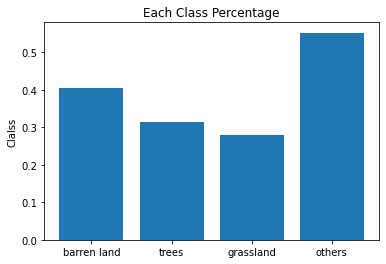

In [21]:
total = 0
for i in range(3):
    total = total + sum[i]
percent = sum / total
objects = ('barren land', 'trees', 'grassland', 'others')
y_pos = np.arange(len(objects))

plt.bar(y_pos, percent, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Clalss')
plt.title('Each Class Percentage')
plt.show()

## Section 3 Model Test

### Section 3.1 Deep neural network

In [28]:
# Now we normalize data. This means we make the mean 0, and the standard deviation 1 for the best results. However, dividing the image by 255 is good enough. We will just divide the array by 255:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [29]:
# Deep neural network model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(3136,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [31]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Train data
r = model.fit(x_train_norm, y_train_np, validation_split=0.2, epochs=100)
# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(x_train_norm, y_train_np))
print("Test score:", model.evaluate(x_test_norm, y_test_np))

Epoch 1/100
10000/10000 [==============================] - 18s 2ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3533 - val_accuracy: 0.3508
Epoch 2/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3528 - val_accuracy: 0.3508
Epoch 3/100
10000/10000 [==============================] - 15s 2ms/step - loss: 1.3502 - accuracy: 0.3573 - val_loss: 1.3531 - val_accuracy: 0.3508
Epoch 4/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3530 - val_accuracy: 0.3508
Epoch 5/100
10000/10000 [==============================] - 13s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3528 - val_accuracy: 0.3508
Epoch 6/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3529 - val_accuracy: 0.3508
Epoch 7/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_

10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3530 - val_accuracy: 0.3508
Epoch 57/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3530 - val_accuracy: 0.3508
Epoch 58/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3530 - val_accuracy: 0.3508
Epoch 59/100
10000/10000 [==============================] - 15s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3529 - val_accuracy: 0.3508
Epoch 60/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3529 - val_accuracy: 0.3508
Epoch 61/100
10000/10000 [==============================] - 15s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 1.3532 - val_accuracy: 0.3508
Epoch 62/100
10000/10000 [==============================] - 14s 1ms/step - loss: 1.3501 - accuracy: 0.3573 - val_loss: 

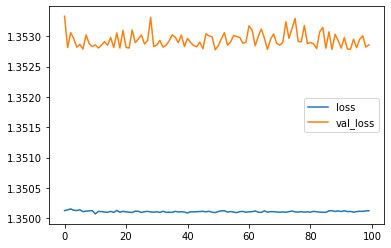

In [40]:
# Plot what's returned by model.fit()
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

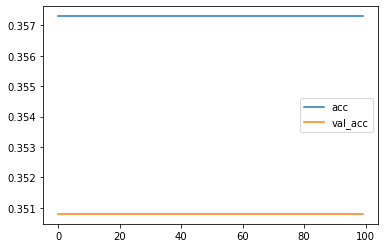

In [41]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

### Section 3.2 Convolution neural network

In [48]:
# Prepare data for cnn model
x_train_img_norm = x_train_img / 255
x_test_img_norm = x_test_img / 255

In [49]:
x_train_img.shape

(400000, 28, 28, 4)

In [50]:
# Build cnn model
Conv2D(10, kernel_size=3, activation='relu')

In [51]:
cnn_model = Sequential()
cnn_model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(28, 28, 4)))
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

In [52]:
# Compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# Fit model
r_cnn = cnn_model.fit(x_train_img_norm, y_train_np, validation_split=0.2, epochs=3)

Epoch 1/3
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2876 - accuracy: 0.9034 - val_loss: 0.1910 - val_accuracy: 0.9375
Epoch 2/3
10000/10000 [==============================] - 39s 4ms/step - loss: 0.1946 - accuracy: 0.9377 - val_loss: 0.1734 - val_accuracy: 0.9392
Epoch 3/3
10000/10000 [==============================] - 38s 4ms/step - loss: 0.1654 - accuracy: 0.9465 - val_loss: 0.1497 - val_accuracy: 0.9464


In [57]:
# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", cnn_model.evaluate(x_train_img_norm, y_train_np))
print("Test score:", cnn_model.evaluate(x_test_img_norm, y_test_np))

12500/12500 [==============================] - 16s 1ms/step - loss: 0.1454 - accuracy: 0.9486
Train score: [0.1454271525144577, 0.9485574960708618]
3125/3125 [==============================] - 5s 2ms/step - loss: 0.1523 - accuracy: 0.9460
Test score: [0.1523299366235733, 0.9460099935531616]


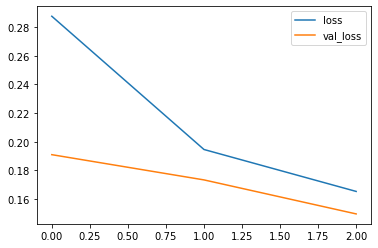

In [58]:
# Plot what's returned by model.fit()
plt.plot(r_cnn.history['loss'], label='loss')
plt.plot(r_cnn.history['val_loss'], label='val_loss')
plt.legend()

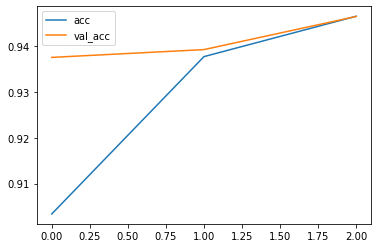

In [59]:
# Plot the accuracy too
plt.plot(r_cnn.history['accuracy'], label='acc')
plt.plot(r_cnn.history['val_accuracy'], label='val_acc')
plt.legend()

### Section 3.3 GAN model

In [69]:
N, H, W, C = x_train_img_norm.shape
D = H * W * C

In [70]:
# Dimensionality of the latent space
latent_dim = 100

In [71]:
# Get the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x)
    
    model = Model(i, x)
    return model

In [72]:
# Get the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i,x)
    return model   

In [73]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# Take true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [103]:
# Train the GAN

# Config
batch_size = 32
epochs = 1000
sample_period = 100 # every 'sample_period' steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [104]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    
    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W, C), cmap='rainbow')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [105]:
# Now we normalize data. This means we make the mean 0, and the standard deviation 1 for the best results. However, dividing the image by 255 is good enough. We will just divide the array by 255:
x_train_np_norm = x_train_np / 255
x_test_np_norm = x_test_np / 255

In [106]:
# Main training loop
for epoch in range(epochs):
    ## Train discriminator##
    
    # Select a random batch of images
    idx = np.random.randint(0, x_train_np_norm.shape[0], batch_size)
    real_imgs = x_train_np_norm[idx]
   
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    #Train the dsicriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real  + d_acc_fake)
    
    
    ## Train generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
              
    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/1000, d_loss: 0.73, d_acc: 0.48, g_loss: 0.85
epoch: 101/1000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.87
epoch: 201/1000, d_loss: 0.71, d_acc: 0.48, g_loss: 0.84
epoch: 301/1000, d_loss: 0.70, d_acc: 0.50, g_loss: 0.83
epoch: 401/1000, d_loss: 0.73, d_acc: 0.48, g_loss: 0.86
epoch: 501/1000, d_loss: 0.74, d_acc: 0.47, g_loss: 0.85
epoch: 601/1000, d_loss: 0.68, d_acc: 0.52, g_loss: 0.83
epoch: 701/1000, d_loss: 0.70, d_acc: 0.50, g_loss: 0.83
epoch: 801/1000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.82
epoch: 901/1000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.86


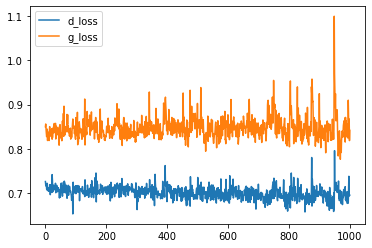

In [115]:
plt.plot(d_losses, label = 'd_loss')
plt.plot(g_losses, label = 'g_loss')
plt.legend()
plt.show()

In [123]:
ls gan_images

 Volume in drive C is OS
 Volume Serial Number is 28DE-85CA

 Directory of C:\Users\Grace-2019\Documents\SpringBoard_Data_Camp\Capstone_project3\satellite_image\cvs_file\gan_images

11/16/2020  03:37 PM    <DIR>          .
11/16/2020  03:37 PM    <DIR>          ..
11/16/2020  02:25 PM           106,316 0.png
11/16/2020  02:33 PM           106,212 100.png
11/16/2020  02:41 PM           105,927 200.png
11/16/2020  02:49 PM           105,440 300.png
11/16/2020  02:57 PM           105,791 400.png
11/16/2020  03:05 PM           106,747 500.png
11/16/2020  03:14 PM           106,690 600.png
11/16/2020  03:22 PM           106,559 700.png
11/16/2020  03:30 PM           106,488 800.png
11/16/2020  03:37 PM           106,515 900.png
              10 File(s)      1,062,685 bytes
               2 Dir(s)  579,724,574,720 bytes free


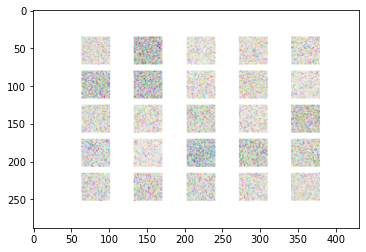

In [120]:
a = imread('gan_images/0.png')
plt.imshow(a)

In [ ]:
# Save model





pandas.core.frame.DataFrame

## Section 4 Model Prediction